In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pyklip.klip
import pyklip.instruments.Instrument as Instrument
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes
import glob
from astropy.table import Table
from astropy.table import join
from astropy.table import vstack
import pandas as pd
import pdb
from tqdm import tqdm

### Create function to generate data 

In [2]:
# Let's specifiy the important variables first. Change this as needed.
mode = 'RDI' 
datadir = 'old_simulated_data'
filtername = "f300m"

In [3]:
def generate_datasets(datadir, filtername,  num_datasets=1, mode = 'ADI'):
    """
    Generates multiple generic datasets based on the two JWST roll angles 0° and 10°
    Args:
        datadir (str): The directory the data is contained in
        filtername (str): The name of the filter you'd like to use
        num_datasets(int): Number of datasets to be generated. Default is 1.
        data_type (str): The type of data reduction you'd like to generate data for (adi or rdi). adi is default
    Returns:
        list: List of generated datasets
        list: Library of 
    """
    if mode not in ('ADI','RDI'):
        raise ValueError(f"Uknown data type {mode}")
    
    # Use this function if mode is adi
    def _process_adi(num_datasets):
        datasets = []
        psflibs = []
        for dataset in range(num_datasets):
            # Read in roll 1
            with fits.open(f"{datadir}/NIRCam_target_Roll1_{filtername}.fits") as hdulist:
                roll1_cube = hdulist[0].data
            # Read in roll 2
            with fits.open(f"{datadir}/NIRCam_target_Roll2_{filtername}.fits") as hdulist:
                roll2_cube = hdulist[0].data
            # Combine the two rows
            full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)
            # Two rolls are offset 10 degrees
            pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])
            # For each image, the (x,y) center where the star is is just the center of the image
            centers = np.array([np.array(frame.shape) // 2.0 for frame in full_seq])
            # Give it some names, just in case we want to refer to them
            filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])
            # Define dataset
            dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
            dataset.flipx = False
            psflib = None
            if num_datasets > 1:
                datasets.append(dataset)
                psflibs.append(psflib)
            else:
                datasets = dataset
                psflibs = psflib
        return datasets, psflibs
    
    # Use this function if mode is rdi
    def _process_rdi(num_datasets):
        datasets = []
        psflibs = []
        for dataset in range(num_datasets):
            # read in ref star
            with fits.open(f"{datadir}/NIRCam_refs_SGD_{filtername}.fits") as hdulist:
                ref_cube = hdulist[0].data
                print(ref_cube.shape)
            # Read in roll 1
            with fits.open(f"{datadir}/NIRCam_target_Roll1_{filtername}.fits") as hdulist:
                roll1_cube = hdulist[0].data
            # Read in roll 2
            with fits.open(f"{datadir}/NIRCam_target_Roll2_{filtername}.fits") as hdulist:
                roll2_cube = hdulist[0].data
                
            # Combine the two rows
            full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

            # Two rolls are offset 10 degrees
            pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

            # For each image, the (x,y) center where the star is is just the center of the image
            centers = np.array([np.array(frame.shape) // 2.0 for frame in full_seq])

            # Give it some names, just in case we want to refer to them
            filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

            # create the GenericData object. This will standardize the data for pyKLIP
            dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
            dataset.flipx = False # get the right handedness of the data

            # combine both science target and reference target images into a psf library array
            psflib_imgs = np.append(ref_cube, full_seq, axis=0)

            ref_filenames = ["ref_{0}".format(i) for i in range(ref_cube.shape[0])]
            psflib_filenames = np.append(ref_filenames, filenames, axis=0)
            # all frames aligned to image center (Which are the same size)
            ref_center = np.array(ref_cube[0].shape)/2

            # make the PSF library
            # we need to compute the correlation matrix of all images vs each other since we haven't computed it before
            psflib = rdi.PSFLibrary(psflib_imgs, ref_center, psflib_filenames, compute_correlation=True)

            if num_datasets > 1:
                datasets.append(dataset)
                psflibs.append(psflib)
            else:
                datasets = dataset
                psflibs = psflib
                
        return datasets, psflibs
    
    return _process_adi(num_datasets) if mode == 'ADI' else _process_rdi(num_datasets) if mode == 'RDI' else None

### Calculate RAW contrast w/ RDI

In [4]:
# Specifying KLIP params. Change as desired
outputdir = "./"
fileprefix = f"pyklip-f300m-{mode}-k50a9s4"
annuli = 9
subsections = 4
movement = 1

# Generate dataset for use
dataset, psflib = generate_datasets(datadir, filtername, num_datasets=1, mode = mode)

if mode == 'RDI':
    psflib.prepare_library(dataset)
    
# Run pyKLIP RDI
parallelized.klip_dataset(dataset, outputdir=outputdir, fileprefix=fileprefix, annuli=annuli, 
                      subsections=subsections, numbasis=[1,5,10,20,50], movement = movement, mode=mode, psf_library=psflib)


(54, 101, 101)
Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Closing threadpool
Derotating Images...
Writing Images to directory /Users/jeaadams/JWST-ERS-Pipeline/notebooks
wavelength collapsing reduced data of shape (b, N, wv, y, x):(5, 12, 1, 101, 101)


### Mask real planets in data

Text(0.5, 1.0, 'Real Planets Masked')

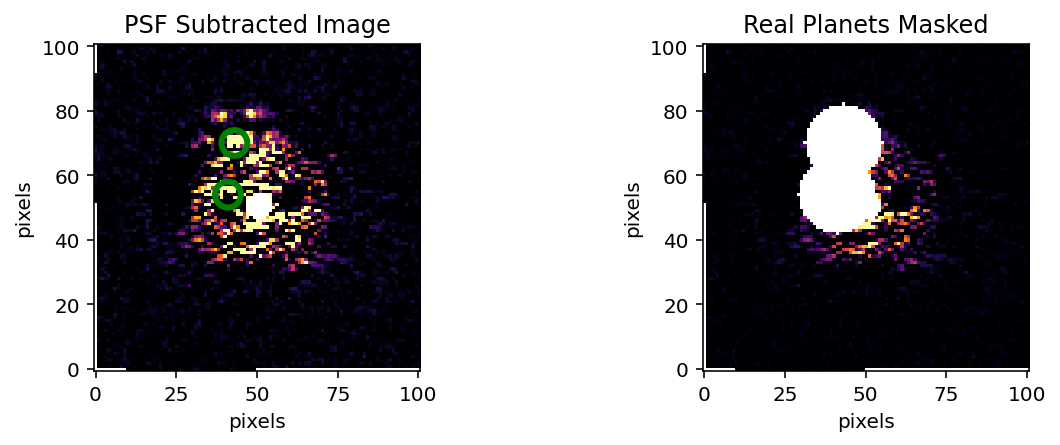

In [5]:
# Read in the KLIP-ed dataset
filesuffix = "-KLmodes-all.fits"

with fits.open(f"{fileprefix}{filesuffix}") as hdulist:
    reduced_cube = hdulist[0].data
    reduced_centers = [hdulist[0].header["PSFCENTX"], hdulist[0].header["PSFCENTY"]]


# Plot the KL10 Cube (index of 2)
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(reduced_cube[2], interpolation="nearest", cmap="inferno", vmin=0, vmax=5)

# Find the positions of the 'real' planets
real_x = [41, 43]
real_y = [54, 70]

# Place green circles around the real planets
for j in range(len(real_x)):
    circle2 = plt.Circle((real_x[j], real_y[j]), 4, fill=False, edgecolor="green", ls="-", linewidth=3)
    ax1.add_artist(circle2)

plt.gca().invert_yaxis()
ax1.set_xlabel("pixels")
ax1.set_ylabel("pixels")
ax1.set_title("PSF Subtracted Image")

# Mask the 1st planet
planet1_peak_x = 41
planet1_peak_y = 54

# Create an array with the indices are that of KL mode frame with index 2
ydat, xdat = np.indices(reduced_cube[2].shape)

# Set the FWHM of the PSF
psf_fwhm = 6

# Calculate the distance around the planet to be masked
distance_from_planet1 = np.sqrt((xdat - planet1_peak_x) ** 2 + (ydat - planet1_peak_y) ** 2)

# Mask
reduced_cube[2][np.where(distance_from_planet1 <= 2 * psf_fwhm)] = np.nan

# Mask the second planet
planet2_peak_x = 43
planet2_peak_y = 70
distance_from_planet2 = np.sqrt((xdat - planet2_peak_x) ** 2 + (ydat - planet2_peak_y) ** 2)
reduced_cube[2][np.where(distance_from_planet2 <= 2 * psf_fwhm)] = np.nan

# Plot the new masked data
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(reduced_cube[2], interpolation="nearest", cmap="inferno", vmin = 0, vmax = 10)
plt.gca().invert_yaxis()
ax2.set_xlabel("pixels")
ax2.set_ylabel("pixels")
ax2.set_title("Real Planets Masked")

### Measure contrast

In [6]:
OWA = 65  # Setting this to be distance between star and outer edge of image

# Measuring the contrast in the image
contrast_seps, contrast = pyklip.klip.meas_contrast(dat=reduced_cube[2], iwa=dataset.IWA, owa=OWA, resolution=(psf_fwhm), center=reduced_centers, low_pass_filter=False)

### Normalize contrast measurements with unocculted psf

In [7]:
# Read in unocculted PSF
with fits.open(f"{datadir}/NIRCam_unocculted_{filtername}.fits") as hdulist:
    psf_cube = hdulist[0].data
    psf_head = hdulist[0].header

# Collapse reference psf in time
psf_frame = np.nanmean(psf_cube, axis=0)

# Find the centroid
bestfit = fakes.gaussfit2d(psf_frame, 71, 30, searchrad=3, guessfwhm=2, guesspeak=1, refinefit=True)

psf_xcen, psf_ycen = bestfit[2:4]
peak_flux = bestfit[0]

# Recenter PSF to that location
x, y = np.meshgrid(np.arange(-20, 20.1, 1), np.arange(-20, 20.1, 1))
x += psf_xcen
y += psf_ycen

psf_stamp = scipy.ndimage.map_coordinates(psf_frame, [y, x])


norm_contrast = contrast / peak_flux

### Define a function that does the planet injection and retrieval

In [8]:
# Read in the transmission profile csv
mask210 = pd.read_csv("MASK210R.csv")

# Create the throughput correction function
def transmission_corrected(input_stamp, input_dx, input_dy):

    """
    Args:
        input_stamp (array): 2D array of the region surrounding the fake planet injection site
        input_dx (array): 2D array specifying the x distance of each stamp pixel from the center
        input_dy (array): 2D array specifying the y distance of each stamp pixel from the center
        
    Returns:
        output_stamp (array): 2D array of the throughput corrected planet injection site.
        """

    # Calculate the distance of each pixel in the input stamp from the center
    distance_from_center = np.sqrt((input_dx) ** 2 + (input_dy) ** 2)

    # Interpolate to find the transmission value for each pixel in the input stamp (we need to turn the columns into arrays so np.interp can accept them)
    distance = np.array(mask210["rad_dist"])
    transmission = np.array(mask210["trans"])
    trans_at_dist = np.interp(distance_from_center, distance, transmission)

    # Reshape the interpolated array to have the same dimensions as the input stamp
    transmission_stamp = trans_at_dist.reshape(input_stamp.shape)

    # Make the throughput correction
    output_stamp = transmission_stamp * input_stamp

    return output_stamp

In [9]:
def multiple_planet_injection(datadir, filtername, seps, input_pas, num_datasets, input_contrasts, mode):
    
    """
    Injects multiple fake planets across multiple datasets.

    Args:
        datadir (str): The name of the directory that the data is contained in
        filtername (str) The name of the filter to be used
        seps (list: int): List of separations each planet should be injected at
        input_pas (list: int): List of position angles to inject fake planets at 
        num_datastes(int): The number of datasets to be generated. This is equal to the number of interations of planet injection/number of position angle changes
        input_contrasts(list: float): List of contrasts planets should be injected at
    Returns:
        retrieved_fluxes_all (list): All retrieved planet fluxes
        pas_all (list): All position angles used for injection
        planet_seps_all (list): All planet separations used for injection
        input_contrasts_all (list): All planet contrasts used for injection
    """
    
    pas_all = []
    retrieved_fluxes_all = []
    planet_seps_all = []
    input_contrasts_all = []
    
    # Generate desired number of datasets: number of loops at each separation
    datasets, psflibs = generate_datasets(datadir, filtername, num_datasets=num_datasets, mode = mode)

    # Begin fake planet injection and retrieval, changing position angle each time
    for dataset_num, dataset, psflib in zip(range(len(datasets)), datasets, psflibs):
        if mode == 'RDI':
            psflib.prepare_library(dataset)

        # Create stamps of the point spread function to be injected as a fake planet
        psf_stamp_input = np.array([psf_stamp for j in range(12)])
        
        # Clock the position angles of the injected planets by 40 each time
        input_pas = [x+40*dataset_num for x in input_pas]

        start_over = False

        # Inject fake planets
        for input_contrast, sep, pa in zip(input_contrasts, seps, input_pas):

            # Check the distance between the planet to be injected and the real planets. We don't want to inject fake planets too close to the two planets already in the data.
            check_sep_x = sep * np.cos((pa + 90))
            check_sep_y = sep * np.sin((pa + 90))
            dist_p1 = np.sqrt((check_sep_x - planet1_peak_x)**2 + (check_sep_y - planet1_peak_y)**2)
            dist_p2 = np.sqrt((check_sep_x - planet2_peak_x)**2 + (check_sep_y - planet2_peak_y)**2)

            # Make sure fake planets won't be injected within a 12 pixel radius of the real planets
            if dist_p1 > 12 and dist_p2 > 12:

                planet_fluxes = psf_stamp_input * input_contrast
                fakes.inject_planet(frames=dataset.input, centers=dataset.centers, inputflux=planet_fluxes, astr_hdrs=dataset.wcs, radius=sep, pa=pa, field_dependent_correction=transmission_corrected)

            # If the fake planet to be injected is within a 12 pixel radius of the real planets, start the loop over
            else:
                start_over = True

        if start_over:
            continue
            
        

        # Run KLIP on datasets with injected planets: Set output directory
        outputdir = "contrastcurves"
        fileprefix = f"FAKE_KLIP_{mode}_A9K5S4M1_{str(dataset_num)}{str(n_sep_loops)}"
        filename =  f"FAKE_KLIP_{mode}_A9K5S4M1_{str(dataset_num)}{str(n_sep_loops)}-KLmodes-all.fits"
        numbasis = [1, 5, 10, 20, 50]

        # Run KLIP 
        parallelized.klip_dataset(dataset, outputdir=outputdir, fileprefix=fileprefix, algo="klip", annuli=9, subsections=4, movement=1, numbasis=numbasis, mode=mode, verbose=False, psf_library=psflib)

        # Open one frame of the KLIP-ed dataset
        klipdataset = os.path.join(outputdir, filename)
        with fits.open(klipdataset) as hdulist:
            outputfile = hdulist[0].data
            outputfile_centers = [hdulist[0].header["PSFCENTX"], hdulist[0].header["PSFCENTY"]]
        outputfile_frame = outputfile[2]

        # Retrieve planet fluxes
        retrieved_planet_fluxes = []
        for input_contrast, sep, pa in zip(input_contrasts, seps, input_pas):

            fake_flux = fakes.retrieve_planet_flux(frames=outputfile_frame, centers=outputfile_centers, astr_hdrs=dataset.output_wcs[0], sep=sep, pa=pa, searchrad=7)
            retrieved_planet_fluxes.append(fake_flux)
        retrieved_fluxes_all.extend(retrieved_planet_fluxes)
        pas_all.extend(input_pas)
        planet_seps_all.extend(seps)
        input_contrasts_all.extend(input_contrasts)
        
    return retrieved_fluxes_all, pas_all, planet_seps_all, input_contrasts_all

### Now use a loop to make numerous measurements!

In [10]:
# Define separation variables 
min_sep = 12
max_sep = 40
nplanets = 4
dist_bt_planets = 3
num_datasets = 3
input_pas = [0, 30, 60, 120]

# Maximum separation of first iteration
max_sep_1 = min_sep + dist_bt_planets * nplanets

# Number of times to iterate to get to max desired separation (max desired sep - max sep in first iteration)
n_sep_loops = max_sep - max_sep_1

retrieved_fluxes_all_rdi = []
output_pas_all_rdi = []
planet_seps_all_rdi = []
output_contrasts_all_rdi = []

for n in tqdm(range(n_sep_loops)):
    # Create array of separations and contrasts to be injected at, spaced by desired distance b/t planets
    seps = np.arange(min_sep + n, max_sep_1 + n, dist_bt_planets)
    input_contrasts = (np.interp(seps, contrast_seps, norm_contrast))*5
    
    retrieved_fluxes, output_pas, output_planet_seps, output_contrasts = multiple_planet_injection(datadir, filtername, seps, input_pas, num_datasets, input_contrasts, mode)
    
    retrieved_fluxes_all_rdi.extend(retrieved_fluxes)
    output_pas_all_rdi.extend(output_pas)
    planet_seps_all_rdi.extend(output_planet_seps)
    output_contrasts_all_rdi.extend(output_contrasts)
    

  0%|          | 0/16 [00:00<?, ?it/s]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


  6%|▋         | 1/16 [00:12<03:02, 12.18s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 12%|█▎        | 2/16 [00:22<02:43, 11.69s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 19%|█▉        | 3/16 [00:39<02:51, 13.16s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 25%|██▌       | 4/16 [00:52<02:36, 13.07s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 31%|███▏      | 5/16 [01:02<02:14, 12.23s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 38%|███▊      | 6/16 [01:12<01:55, 11.54s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 44%|████▍     | 7/16 [01:22<01:39, 11.11s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 50%|█████     | 8/16 [01:32<01:26, 10.79s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 56%|█████▋    | 9/16 [01:42<01:13, 10.54s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 62%|██████▎   | 10/16 [01:52<01:02, 10.38s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 69%|██████▉   | 11/16 [02:02<00:51, 10.31s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 75%|███████▌  | 12/16 [02:12<00:40, 10.21s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 81%|████████▏ | 13/16 [02:22<00:30, 10.17s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 88%|████████▊ | 14/16 [02:32<00:20, 10.09s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


 94%|█████████▍| 15/16 [02:42<00:10, 10.17s/it]

(54, 101, 101)
(54, 101, 101)
(54, 101, 101)


100%|██████████| 16/16 [02:53<00:00, 10.82s/it]


In [13]:
# Create a table of all variables
flux_sep_rdi = Table([retrieved_fluxes_all_rdi, planet_seps_all_rdi, output_contrasts_all_rdi, output_pas_all_rdi], names=("flux", "separation", "input_contrast", "pas"))
flux_sep_rdi["input_flux"] = flux_sep_rdi["input_contrast"] * bestfit[0]

# Calculate throughput and add it to the table
flux_sep_rdi["throughput"] = flux_sep_rdi["flux"] / flux_sep_rdi["input_flux"]

# Group by separation
med_flux_sep_rdi = flux_sep_rdi.group_by("separation")

# Calculate the median value for each separation group
med_flux_sep_rdi = med_flux_sep_rdi.groups.aggregate(np.median)

# Find the 5 sigma contrast for each separation used in calculation
med_flux_sep_rdi['5sig_contrast']=np.interp(med_flux_sep_rdi['separation'],contrast_seps, norm_contrast)

# Normalize the noise contrast by the measured throughput level at that separation
med_flux_sep_rdi["corrected_contrast"] = (med_flux_sep_rdi["5sig_contrast"] / med_flux_sep_rdi["throughput"])

### Now do the same thing for adi!

In [14]:
mode = 'ADI'

Compute contrast measurement again!

In [15]:
# Specifying KLIP params. Change as desired
outputdir = "./"
fileprefix = f"pyklip-f300m-{mode}-k50a9s4"
annuli = 9
subsections = 4
movement = 1

# Generate dataset for use
dataset, psflib = generate_datasets(datadir, filtername, num_datasets=1, mode = mode)

if mode == 'RDI':
    psflib.prepare_library(dataset)
    
# Run pyKLIP RDI
parallelized.klip_dataset(dataset, outputdir=outputdir, fileprefix=fileprefix, annuli=annuli, 
                      subsections=subsections, numbasis=[1,5,10,20,50], movement = movement, mode=mode, psf_library=psflib)


# Read in the KLIP-ed dataset
filesuffix = "-KLmodes-all.fits"

with fits.open(f"{fileprefix}{filesuffix}") as hdulist:
    reduced_cube = hdulist[0].data
    reduced_centers = [hdulist[0].header["PSFCENTX"], hdulist[0].header["PSFCENTY"]]


# Find the positions of the 'real' planets
real_x = [41, 43]
real_y = [54, 70]

# Mask the 1st planet
planet1_peak_x = 41
planet1_peak_y = 54

# Create an array with the indices are that of KL mode frame with index 2
ydat, xdat = np.indices(reduced_cube[2].shape)

# Set the FWHM of the PSF
psf_fwhm = 6

# Calculate the distance around the planet to be masked
distance_from_planet1 = np.sqrt((xdat - planet1_peak_x) ** 2 + (ydat - planet1_peak_y) ** 2)

# Mask
reduced_cube[2][np.where(distance_from_planet1 <= 2 * psf_fwhm)] = np.nan

# Mask the second planet
planet2_peak_x = 43
planet2_peak_y = 70
distance_from_planet2 = np.sqrt((xdat - planet2_peak_x) ** 2 + (ydat - planet2_peak_y) ** 2)
reduced_cube[2][np.where(distance_from_planet2 <= 2 * psf_fwhm)] = np.nan

OWA = 65  # Setting this to be distance between star and outer edge of image

# Measuring the contrast in the image
contrast_seps_adi, contrast_adi = pyklip.klip.meas_contrast(dat=reduced_cube[2], iwa=dataset.IWA, owa=OWA, resolution=(psf_fwhm), center=reduced_centers, low_pass_filter=False)

norm_contrast_adi = contrast_adi / peak_flux

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Closing threadpool
Derotating Images...
Writing Images to directory /Users/jeaadams/JWST-ERS-Pipeline/notebooks
wavelength collapsing reduced data of shape (b, N, wv, y, x):(5, 12, 1, 101, 101)


In [16]:
# Define separation variables 
min_sep = 12
max_sep = 40
nplanets = 4
dist_bt_planets = 3
num_datasets = 3
input_pas = [0, 30, 60, 120]

# Maximum separation of first iteration
max_sep_1 = min_sep + dist_bt_planets * nplanets

# Number of times to iterate to get to max desired separation (max desired sep - max sep in first iteration)
n_sep_loops = max_sep - max_sep_1

retrieved_fluxes_all_adi = []
output_pas_all_adi = []
planet_seps_all_adi = []
output_contrasts_all_adi = []

for n in tqdm(range(n_sep_loops)):
    # Create array of separations and contrasts to be injected at, spaced by desired distance b/t planets
    seps = np.arange(min_sep + n, max_sep_1 + n, dist_bt_planets)
    input_contrasts = (np.interp(seps, contrast_seps, norm_contrast_adi))*5
    
    retrieved_fluxes, output_pas, output_planet_seps, output_contrasts = multiple_planet_injection(datadir, filtername, seps, input_pas, num_datasets, input_contrasts, mode)
    
    retrieved_fluxes_all_adi.extend(retrieved_fluxes)
    output_pas_all_adi.extend(output_pas)
    planet_seps_all_adi.extend(output_planet_seps)
    output_contrasts_all_adi.extend(output_contrasts)
    

100%|██████████| 16/16 [01:45<00:00,  6.61s/it]


In [19]:
# Create a table of all variables
flux_sep_adi = Table([retrieved_fluxes_all_adi, planet_seps_all_adi, output_contrasts_all_adi, output_pas_all_adi], names=("flux", "separation", "input_contrast", "pas"))
flux_sep_adi["input_flux"] = flux_sep_adi["input_contrast"] * bestfit[0]

# Calculate throughput and add it to the table
flux_sep_adi["throughput"] = flux_sep_adi["flux"] / flux_sep_adi["input_flux"]

# Group by separation
med_flux_sep_adi = flux_sep_adi.group_by("separation")

# Calculate the median value for each separation group
med_flux_sep_adi = med_flux_sep_adi.groups.aggregate(np.median)

# Find the 5 sigma contrast for each separation used in calculation
med_flux_sep_adi['5sig_contrast']=np.interp(med_flux_sep_adi['separation'],contrast_seps_adi, norm_contrast_adi)

# Normalize the noise contrast by the measured throughput level at that separation
med_flux_sep_adi["corrected_contrast"] = (med_flux_sep_adi["5sig_contrast"] / med_flux_sep_adi["throughput"])

Text(0.5, 0, 'Separation (pixels)')

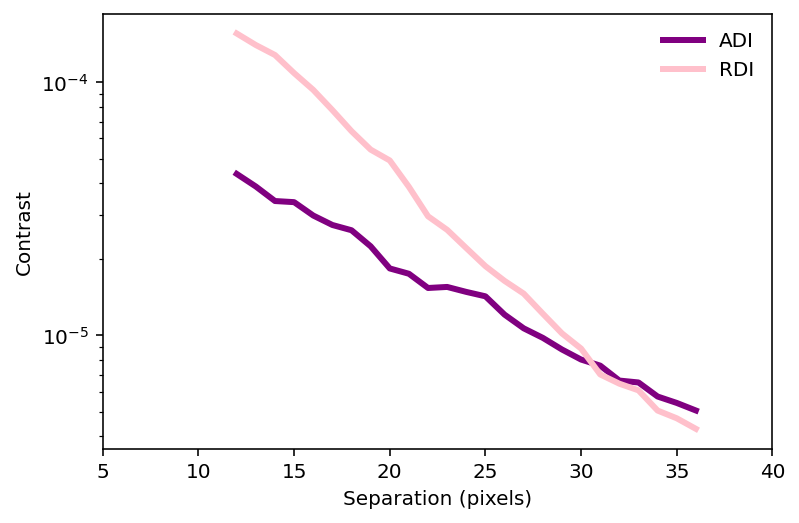

In [20]:
#plt.plot(med_flux_sep["separation"], med_flux_sep["corrected_contrast"], color="purple", linewidth = 3, label = 'RDI')
plt.plot(med_flux_sep_adi["separation"], med_flux_sep_adi["corrected_contrast"], color="purple", linewidth = 3, label = 'ADI')
plt.plot(med_flux_sep_rdi["separation"], med_flux_sep_rdi["corrected_contrast"], color="pink", linewidth = 3, label = 'RDI')
plt.legend(frameon = False)
plt.xlim(5,40)
plt.yscale('log')
plt.ylabel("Contrast")
plt.xlabel("Separation (pixels)")